In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp
import copy
import math
import itertools as iter

(trainingImages, trainingLabels), (testImages, testLabels) = cifar10.load_data()

In [2]:
#method for quantizing a numpy array
def quantisation(inputArray, bitSize, fractBits = 0):
     #compute scale and zeroPoint
    maximum = np.max(inputArray);
    minimum = np.min(inputArray);
    valueRange = maximum - minimum;
    
    #using a fxpMath dummy to get the bounds for quantisation
    fxDummy = Fxp(1,signed = (minimum < 0), n_word = bitSize, n_frac = fractBits)
    maxFpVal = fxDummy.upper
    minFpVal = fxDummy.lower

    #scale = 1 when only one value is present to avoid division by 0
    scale = 1;
    if (valueRange != 0):
        scale = (maxFpVal - minFpVal) / valueRange;
    zeroPoint = minFpVal-(scale*minimum);
    
    #the actual quantisation and restructuring into a fxp-array
    output = Fxp((inputArray * scale) + zeroPoint, (minimum < 0), bitSize, fractBits)

    return output;

def fixedPointConversion(inputArray, bitSize, fractBits = 0):
    output = Fxp(inputArray, signed= True, n_word = bitSize, n_frac = fractBits)
    return (output)

def computeFractBits(weights, biases):
    #get only absolute fractional values of the layer
    weights = np.abs(np.modf(weights)[0])
    weights = np.where(weights == 0, 1, weights)
    biases = np.abs(np.modf(biases)[0])
    biases = np.where(biases == 0, 1, biases)

    #list for storing the sum of the values
    sums = [np.sum(weights) + np.sum(biases)]

    #range can be adjusted
    #continously remove 0.5 the doubles all values
    #(if only ideal values are wanted, log2 can also be used)
    for i in range (16):
        weights = np.where(weights > 0.5, weights - 0.5, weights)
        biases = np.where(biases > 0.5, biases - 0.5, biases)
        sums.append(np.sum(weights) + np.sum(biases))
        weights = weights * 2
        biases = biases * 2

    #returns the index, where the Values stabilize 
    stableValue = sums[len(sums) - 1] 
    for i in range(len(sums)):
        if (sums[i] == stableValue):
            return i
    
    #return value, to catch non-stabilizing Weights
    return -1

In [26]:
#Composited function
def quantizeModel(model, testImages, testLabels, quantizationMethod = "linear", evaluationMethod = "bestAccuracy", tolerance = 0):
    
    #set up needed variables
    #copy of model for testing current weights
    modelCpy = copy.deepcopy(model)
    layerCount = len(model.layers)
    fractBitsSearchSpace = [2,4,8]
    #list for the computed needed decimal bits
    decimalBits = []
    #list of indices of layers with weights
    nonEmptyLayerIdx = []
    #storage of the chosen quantizatin bits
    chosenParameters = []

    #get indices of all layers with weights
    for idx in range(layerCount):
        if (modelCpy.layers[idx].get_weights() != []):
            nonEmptyLayerIdx.append(idx)

    print("non-empty-Layers:")
    print(nonEmptyLayerIdx)

    #determine the needed decimal bits
    for layerIdx in range(layerCount):
        #case for empty layers
        if not(layerIdx in nonEmptyLayerIdx):
            decimalBits.append(0)
        else:
            #determine log2 of maximum range
            minimum = math.floor(min(np.min(modelCpy.layers[layerIdx].get_weights()[0]), np.min(modelCpy.layers[layerIdx].get_weights()[1])))  
            maximum = math.ceil(max(np.max(modelCpy.layers[layerIdx].get_weights()[0]), np.max(modelCpy.layers[layerIdx].get_weights()[1])))
            valueRange = max(maximum, 0) - min(minimum, 0)
            #safety check
            if (valueRange > 0):
                decimalBits.append(math.ceil(math.log(valueRange, 2)))
            else:
                print("Error: Value Range is 0 or negative")

    print("decimal Bits:")
    print(decimalBits)
    
    ##run chosen quantization method
    match quantizationMethod:
        case "linear":
            chosenBits =[]
            for layerIdx in nonEmptyLayerIdx:
                currentFractBits = computeFractBits(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), copy.deepcopy(model.layers[layerIdx].get_weights()[1]))
                chosenBits.append(currentFractBits + decimalBits[layerIdx])
                newLayer = []
                newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
                newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
                modelCpy.layers[layerIdx].set_weights(newLayer)
            test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
            chosenParameters = chosenBits
        case "quadratic":
            #optimizes layer by layer
            for currentLayer in nonEmptyLayerIdx:
                accuracies = []
                originalLayer = copy.deepcopy(model.layers[currentLayer].get_weights())
                #iterates over specified numberfs of fractional bits, and specified number of overall bits for each
                for fractBitsIdx in range(len(fractBitsSearchSpace)):
                            #initializes a new container for all weights of the current layer
                            newLayer = []
                            #iterates over all sets of weights in layer (needed, because the list of all weights has inhomogenus shape, so numpy cant handle it)
                            newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer[0]), decimalBits[layerIdx], fractBitsSearchSpace[fractBitsIdx]))
                            newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer[1]), decimalBits[layerIdx], fractBitsSearchSpace[fractBitsIdx]))
                            #sets the new layer
                            modelCpy.layers[currentLayer].set_weights(newLayer)
                            #tests the new accuracy and stores it in a matrix
                            test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
                            accuracies.append(test_acc)

                #evaluate current layer based on chosen method
                bestAccuracyIndex = 0
                match evaluationMethod:                    
                    case "ratio":
                    #determine best suited Values by computing the ratios of bits to accuracy
                    #exclude accuracies below a certain border (tolerance)
                        ratios = []
                        minimumAccuracy = max(accuracies) - tolerance
                        for idx in range(len(accuracies)):
                            if (accuracies[idx] < minimumAccuracy):
                                ratios.append(0)
                            else:
                                ratios.append(fractBitsSearchSpace[idx] / accuracies[idx])
                        bestAccuracyIndex = ratios.index(max(ratios))
                    case "toleranceBorder":
                        #only update, if new accuracies exceeds old one by a chosen amount (tolerance)
                        for idx in range(len(accuracies)):
                            if ((accuracies[idx] - tolerance) > accuracies[bestAccuracyIndex]):
                                bestAccuracyIndex = idx
                    case "bestAccuracy":
                        #simply determine best accuracy
                        bestAccuracyIndex = accuracies.index(max(accuracies))
                    case _:
                        print("Error in matching choosen evaluation method")
                        print("should be either ratio, toleranceBorder, or bestAcccuracy, but is: " + evaluationMethod)
                        return -1
                    
                chosenParameters.append(fractBitsSearchSpace[bestAccuracyIndex])

        case "exponential":
            #iterate over all permutations and test the accuracy
            permutations = list(iter.product(fractBitsSearchSpace, repeat = len(nonEmptyLayerIdx)))
            print("goal: " + str(len(permutations)) + " permutations")
            accuracies = []
            for permutation in range(len(permutations)):
                for layerIdx in nonEmptyLayerIdx:
                    currentFractBits = permutations[permutation][nonEmptyLayerIdx.index(layerIdx)]
                    newLayer = []
                    newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
                    newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
                    modelCpy.layers[layerIdx].set_weights(newLayer)
                test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
                accuracies.append(test_acc)
                print("run: " + str(permutation))
                print(test_acc)

            print ("length of accuracies and permutations. should be equal:")
            print(len(accuracies), len(permutations))

            ##determine best parameter by maximizing accuracy by chosen method
            bestAccuracyIndex = 0
            match evaluationMethod:
                case "ratio":
                    #determine best suited Values by computing the ratios of bits to accuracy
                    #exclude accuracies below a certain border (tolerance)
                    ratios = []
                    minimumAccuracy = max(accuracies) - tolerance
                    for idx in range(len(accuracies)):
                        if (accuracies[idx] < minimumAccuracy):
                            ratios.append(0)
                        else:
                            ratios.append(sum(permutations[idx]) / accuracies[idx])
                    bestAccuracyIndex = ratios.index(max(ratios))
                case "toleranceBorder":
                    #only update, if new accuracy exceeds old one by a chosen amount (tolerance)
                    for idx in range(len(accuracies)):
                        if ((accuracies[idx] - tolerance) > accuracies[bestAccuracyIndex]):
                            bestAccuracyIndex = idx
                case "bestAccuracy":
                    #simply determine best accuracy
                    bestAccuracyIndex = accuracies.index(max(accuracies))
                case _:
                    print("Error in matching choosen evaluation method")
                    print("should be either ratio, toleranceBorder, or bestAcccuracy, but is: " + evaluationMethod)
                    return -1
                
            chosenParameters = permutations[bestAccuracyIndex]
        case _:
            print("Error in matching choosen quantisation method")
            print("should be either linear, quadratic, or exponential, but is: " + quantizationMethod)
            return -1            

    
        
    #apply quantisation to model and return
    print(chosenParameters)
    for layerIdx in nonEmptyLayerIdx:
        currentFractBits = chosenParameters[nonEmptyLayerIdx.index(layerIdx)]
        newLayer = []
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        modelCpy.layers[layerIdx].set_weights(newLayer)

    test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
    print("new accuracy")
    print(test_acc)
    print("mean used Bits")
    print(sum(chosenParameters)/len(chosenParameters))

    return modelCpy
    




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

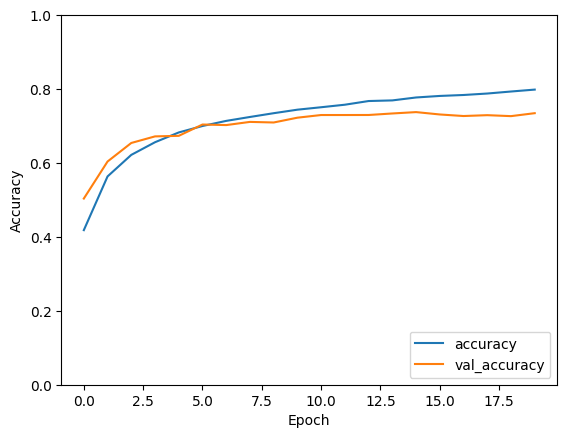

313/313 - 1s - loss: 0.8053 - accuracy: 0.7347 - 550ms/epoch - 2ms/step
0.7347000241279602


In [3]:
#normalizing the values to 0-1
trainingImages = trainingImages / 255.0
testImages = testImages / 255.0

# One hot encoding the target class (labels)
num_classes = 10
trainingLabels = tf.keras.utils.to_categorical(trainingLabels, num_classes)
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes)

#convolution layers for feature extraction
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.1))


#fully connected layers for class prediction
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

#print the current model summary
model.summary()

#preparing model for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#training the model
history = model.fit(trainingImages, trainingLabels, epochs=20, 
                    validation_data=(testImages, testLabels))

#set to True to display the changing accuracy of the model during training
if(True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

#display the accuracy of the trained model
test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
print(test_acc)

#get the weights of the model 
weights = model.get_weights()

In [9]:
#save model
model.save("trained_classifier")

INFO:tensorflow:Assets written to: trained_classifier\assets


INFO:tensorflow:Assets written to: trained_classifier\assets


In [4]:
#load model
model = tf.keras.models.load_model("trained_classifier")

In [29]:
##quantize model using function above
newModel = quantizeModel(model = model, testImages = testImages, testLabels = testLabels,quantizationMethod = "linear", evaluationMethod= "ratio", tolerance = 0.4 )

non-empty-Layers:
[0, 3, 6, 9, 10, 11]
decimal Bits:
[1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 2]
goal: 729 permutations
run: 0
0.10000000149011612
run: 1
0.10000000149011612
run: 2
0.10000000149011612
run: 3
0.10000000149011612
run: 4
0.10000000149011612
run: 5
0.10000000149011612
run: 6
0.10000000149011612
run: 7
0.09960000216960907
run: 8
0.0997999981045723
run: 9
0.10000000149011612
run: 10
0.10000000149011612
run: 11
0.10000000149011612
run: 12
0.10000000149011612
run: 13
0.10000000149011612
run: 14
0.10000000149011612
run: 15
0.10000000149011612
run: 16
0.09989999979734421
run: 17
0.09989999979734421
run: 18
0.10000000149011612
run: 19
0.10000000149011612
run: 20
0.10000000149011612
run: 21
0.10000000149011612
run: 22
0.10000000149011612
run: 23
0.10000000149011612
run: 24
0.10010000318288803
run: 25
0.09989999979734421
run: 26
0.10000000149011612
run: 27
0.10000000149011612
run: 28
0.10000000149011612
run: 29
0.10000000149011612
run: 30
0.10000000149011612
run: 31
0.10000000149011612
ru

In [5]:
###second Version (testing every permutation)

#set up needed variables
modelCpy = copy.deepcopy(model)
layerCount = len(model.layers)
fractBitsSearchSpace = [2,4,8]
tolerance = 0.1
decimalBits = []
nonEmptyLayerIdx = []
accuracies = []

#get indices of all layers with weights
for idx in range(layerCount):
    if (modelCpy.layers[idx].get_weights() != []):
        nonEmptyLayerIdx.append(idx)

print("non-empty-Layers:")
print(nonEmptyLayerIdx)

#determine the needed decimal bits
for layerIdx in range(layerCount):
    #case for empty layers
    if not(layerIdx in nonEmptyLayerIdx):
        decimalBits.append(0)
    else:
        #determine log2 of maximum range
        minimum = math.floor(min(np.min(modelCpy.layers[layerIdx].get_weights()[0]), np.min(modelCpy.layers[layerIdx].get_weights()[1])))  
        maximum = math.ceil(max(np.max(modelCpy.layers[layerIdx].get_weights()[0]), np.max(modelCpy.layers[layerIdx].get_weights()[1])))
        valueRange = max(maximum, 0) - min(minimum, 0)
        #safety check
        if (valueRange > 0):
            decimalBits.append(math.ceil(math.log(valueRange, 2)))
        else:
            print("Error: Value Range is 0 or negative")

print("decimal Bits:")
print(decimalBits)

#iterate over all permutations and test the accuracy
permutations = list(iter.product(fractBitsSearchSpace, repeat = len(nonEmptyLayerIdx)))
print("goal: " + str(len(permutations)) + " permutations")
for permutation in range(len(permutations)):
    for layerIdx in nonEmptyLayerIdx:
        currentFractBits = permutations[permutation][nonEmptyLayerIdx.index(layerIdx)]
        newLayer = []
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        modelCpy.layers[layerIdx].set_weights(newLayer)
    test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
    accuracies.append(test_acc)
    print("run: " + str(permutation))
    print(test_acc)

print ("length of accuracies and permutations. should be equal:")
print(len(accuracies), len(permutations))

#determine best suited Values by computing the ratios of bits to accuracy
ratios = []
minimumAccuracy = max(accuracies) - tolerance
for idx in range(len(permutations)):
    if (accuracies[idx] < minimumAccuracy):
        ratios.append(0)
    else:
        ratios.append(sum(permutations[idx]) / accuracies[idx])

bestPermutation = permutations[ratios.index(max(ratios))]
for layerIdx in nonEmptyLayerIdx:
        currentFractBits = bestPermutation[nonEmptyLayerIdx.index(layerIdx)]
        newLayer = []
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        modelCpy.layers[layerIdx].set_weights(newLayer)

test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
print("new accuracy")
print(test_acc)
print("mean used Bits")
print(sum(bestPermutation)/len(bestPermutation))


[0, 3, 6, 9, 10, 11]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
729
[(2, 2, 2, 2, 2, 2), (2, 2, 2, 2, 2, 4), (2, 2, 2, 2, 2, 8), (2, 2, 2, 2, 4, 2), (2, 2, 2, 2, 4, 4), (2, 2, 2, 2, 4, 8), (2, 2, 2, 2, 8, 2), (2, 2, 2, 2, 8, 4), (2, 2, 2, 2, 8, 8), (2, 2, 2, 4, 2, 2), (2, 2, 2, 4, 2, 4), (2, 2, 2, 4, 2, 8), (2, 2, 2, 4, 4, 2), (2, 2, 2, 4, 4, 4), (2, 2, 2, 4, 4, 8), (2, 2, 2, 4, 8, 2), (2, 2, 2, 4, 8, 4), (2, 2, 2, 4, 8, 8), (2, 2, 2, 8, 2, 2), (2, 2, 2, 8, 2, 4), (2, 2, 2, 8, 2, 8), (2, 2, 2, 8, 4, 2), (2, 2, 2, 8, 4, 4), (2, 2, 2, 8, 4, 8), (2, 2, 2, 8, 8, 2), (2, 2, 2, 8, 8, 4), (2, 2, 2, 8, 8, 8), (2, 2, 4, 2, 2, 2), (2, 2, 4, 2, 2, 4), (2, 2, 4, 2, 2, 8), (2, 2, 4, 2, 4, 2), (2, 2, 4, 2, 4, 4), (2, 2, 4, 2, 4, 8), (2, 2, 4, 2, 8, 2), (2, 2, 4, 2, 8, 4), (2, 2, 4, 2, 8, 8), (2, 2, 4, 4, 2, 2), (2, 2, 4, 4, 2, 4), (2, 2, 4, 4, 2, 8), (2, 2, 4, 4, 4, 2), (2, 2, 4, 4, 4, 4), (2, 2, 4, 4, 4, 8), (2, 2, 4, 4, 8, 2), (2, 2, 4, 4, 8, 4), (2, 2, 4, 4, 8, 8), (2, 2, 4, 8, 2, 2), (2, 2, 4, 8, 2, 4

In [5]:
###third version (evaluating the needed FractionalBits)

#quantization
modelCpy = copy.deepcopy(model)
layerCount = len(model.layers)
fractBitsSearchSpace = [2,4,8]
nonEmptyLayerIdx = []
decimalBits = []

##get indices of all layers with weights
for idx in range(layerCount):
    if (modelCpy.layers[idx].get_weights() != []):
        nonEmptyLayerIdx.append(idx)

print("non-empty-Layers:")
print(nonEmptyLayerIdx)

###todo optimize
for layerIdx in range(layerCount):
    if not(layerIdx in nonEmptyLayerIdx):
        decimalBits.append(0)
    else:
        minimum = math.floor(min(np.min(modelCpy.layers[layerIdx].get_weights()[0]), np.min(modelCpy.layers[layerIdx].get_weights()[1])))  
        maximum = math.ceil(max(np.max(modelCpy.layers[layerIdx].get_weights()[0]), np.max(modelCpy.layers[layerIdx].get_weights()[1])))
        valueRange = max(maximum, 0) - min(minimum, 0)
        if (valueRange > 0):
            decimalBits.append(math.ceil(math.log(valueRange, 2)))
        else:
            print("Error: Value Range is 0 or negative")

print("decimal Bits:")
print(decimalBits)

chosenBits =[]
for layerIdx in nonEmptyLayerIdx:
    currentFractBits = computeFractBits(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), copy.deepcopy(model.layers[layerIdx].get_weights()[1]))
    chosenBits.append(currentFractBits + decimalBits[layerIdx])
    newLayer = []
    newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
    newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
    modelCpy.layers[layerIdx].set_weights(newLayer)
test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
print("accuracy:")
print(test_acc)
print("with mean Bits:")
print(np.sum(chosenBits)/len(chosenBits))

non-empty-Layers:
[0, 3, 6, 9, 10, 11]
decimal Bits:
[1, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 2]



c:\Users\7Zylo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



accuracy:
0.6779000163078308
with mean Bits:
17.666666666666668


Layer: 0 bits: 6 fractional Bits: 6 Accuracy: 
0.7366999983787537
Layer: 3 bits: 4 fractional Bits: 4 Accuracy: 
0.7233999967575073
Layer: 6 bits: 4 fractional Bits: 4 Accuracy: 
0.7164000272750854
Layer: 9 bits: 4 fractional Bits: 4 Accuracy: 
0.7146999835968018
Layer: 10 bits: 4 fractional Bits: 4 Accuracy: 
0.7085999846458435
Layer: 11 bits: 4 fractional Bits: 4 Accuracy: 
0.7106000185012817


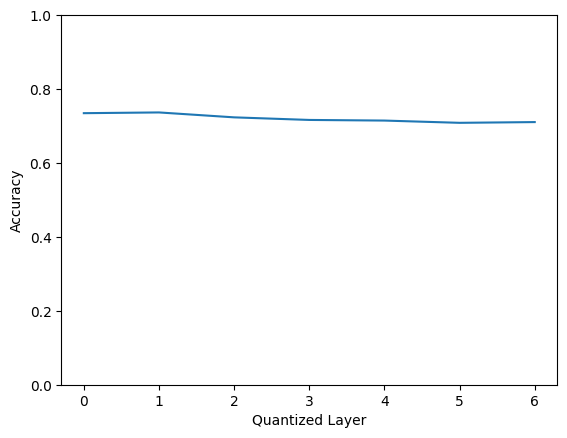

average storage use: 4.333333333333333 Bits


In [4]:
###first Version (layer by layer)
fractBitsList = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
maxBitSize = 24
tolerancePerLayer = 0.05
layerCount = len(model.layers)
averageStorageUse = []
accuracyDeveloptment = [test_acc]

#optimizes layer by layer
for currentLayer in range(layerCount):
    originalLayer = copy.deepcopy(model.layers[currentLayer])
    #only computes if layer has weights
    if (originalLayer.get_weights() != []):
        #initializes matrix for storing layer accuracy
        layerAccuracy =  np.zeros((maxBitSize, len(fractBitsList)))
        #iterates over specified numberfs of fractional bits, and specified number of overall bits for each
        for fractBitsIdx in range(len(fractBitsList)):
            for bits in range(max(fractBitsList[fractBitsIdx], 1), maxBitSize + 1):
                #initializes a new container for all weights of the current layer
                newLayer = []
                #iterates over all sets of weights in layer (needed, because the list of all weights has inhomogenus shape, so numpy cant handle it)
                for weightCount in range(len(originalLayer.get_weights())):
                    #append the quantized weights to new layer
                    newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bits, fractBitsList[fractBitsIdx]))
                #sets the new layer
                model.layers[currentLayer].set_weights(newLayer)
                #tests the new accuracy and stores it in a matrix
                test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
                layerAccuracy[bits-1][fractBitsIdx] = test_acc        

        #detecting the best accuracy by tolerance
        #ToDo: optimize the function picking the best sizes
        bestAccuracy = {"bitIdx" : 0, "fractIdx" : 0, "accuracy" : 0}
        for bits in range(maxBitSize):
            for fractBits in range(len(fractBitsList)):
                if ((layerAccuracy[bits][fractBits] - tolerancePerLayer) > bestAccuracy["accuracy"]):
                    bestAccuracy["bitIdx"] = bits
                    bestAccuracy["fractIdx"] = fractBits
                    bestAccuracy["accuracy"] = layerAccuracy[bits][fractBits]
        
        #set the final new weights
        if (bestAccuracy["bitIdx"] > 0):
            newLayer = []
            for weightCount in range(len(originalLayer.get_weights())):
                newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bestAccuracy["bitIdx"] + 1, fractBitsList[bestAccuracy["fractIdx"]]))
            model.layers[currentLayer].set_weights(newLayer)
        print("Layer: " + str(currentLayer) + " bits: " + str(bestAccuracy["bitIdx"] + 1) + " fractional Bits: " + str(fractBitsList[bestAccuracy["fractIdx"]]) + " Accuracy: ")
        averageStorageUse.append(bestAccuracy["bitIdx"] + 1)
        test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
        print (test_acc)
        accuracyDeveloptment.append(test_acc)

plt.xlabel("Quantized Layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.plot(accuracyDeveloptment)
plt.show()

print("average storage use: " + str(np.mean(averageStorageUse)) + " Bits")